In [26]:
class TabularDataset:
    def __init__(self, id=2):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id

        # Fetch the dataset
        self.fetch_dataset()

        # Preprocess data
        self.preprocess_data()
        self.split_data()
    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
            # Load data and targets
            X = self.dataset.data.features
            y = self.dataset.data.targets
            
            
            # Identify non-numeric columns
            df = pd.DataFrame(data=np.column_stack((X, y))).astype(str)
            df = df.replace('?', np.nan).dropna()
    
            numeric_df = df.apply(pd.to_numeric, errors='coerce')
            nan_columns = numeric_df.columns[numeric_df.isna().any()].tolist()
            numeric_df[nan_columns] = df[nan_columns]
            df = numeric_df
            non_numeric_columns = df.select_dtypes(exclude=['int', 'float']).columns
            
            # Convert non-numeric columns to numeric, replace NaN with original values
            mask = df[14].str.contains('\.', na=False)
            mask2 = ~df[14].str.contains('\.', na=False)
            # Use boolean indexing to get the rows with a full stop
            test_df = df[mask]
            train_df = df[mask2]
    
            label_encoder = LabelEncoder()
            for non_numeric_column in non_numeric_columns:
                test_df[non_numeric_column] = label_encoder.fit_transform(test_df[non_numeric_column])
                train_df[non_numeric_column] = label_encoder.fit_transform(train_df[non_numeric_column])
            # Convert non-numeric features to numeric types
            self.X_train = train_df.iloc[:, :-1].values
            self.X_test = test_df.iloc[:, :-1].values
            self.y_train = train_df.iloc[:, -1].values
            self.y_test = test_df.iloc[:, -1].values
    

    def split_data(self):
        # Split the dataset into training and testing sets
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train, self.y_train, test_size=0.2, random_state=42
        )

    def standardize_data(self):
        # Standardize the data (optional but recommended for neural networks)
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        # Convert NumPy arrays to PyTorch tensors
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        # Create PyTorch datasets and dataloaders
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)
        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)


In [37]:
!pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import json

In [7]:
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline  # Import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader, TensorDataset

In [44]:
class KNNWithPCA:
    def __init__(self, n_neighbors=5, n_components=50):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.model = self._build_pipeline()

    def _build_pipeline(self):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=self.n_components)),
            ('knn', KNeighborsClassifier(n_neighbors=self.n_neighbors))
        ])
        return pipeline

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        return accuracy, report

    def tune_hyperparameters(self, X_train, y_train, param_grid, cv=5, n_jobs=-1):
        explained_variance_threshold = 1 # Adjust as needed

        pca_n_components = [n for n in param_grid['pca__n_components'] if n > 0]
        grid_search = GridSearchCV(self.model, param_grid, cv=cv, n_jobs=n_jobs, scoring='f1_macro')

        # Add logic to check explained variance
        best_explained_variance = 0.0
        best_pca_components = None

        for n_components in pca_n_components:
            self.model.named_steps['pca'].set_params(n_components=n_components)
            grid_search.fit(X_train, y_train)

            # Check if explained variance meets the threshold
            explained_variance_ratio = np.sum(grid_search.best_estimator_.named_steps['pca'].explained_variance_ratio_)
            if explained_variance_ratio > explained_variance_threshold and explained_variance_ratio > best_explained_variance:
                best_explained_variance = explained_variance_ratio
                best_pca_components = n_components


        # Update the param_grid with the best PCA components
        param_grid['pca__n_components'] = [best_pca_components] if best_pca_components is not None else pca_n_components

        # Rerun grid search with the updated param_grid
        grid_search = GridSearchCV(self.model, param_grid, cv=cv, n_jobs=n_jobs, scoring='f1_macro')
        grid_search.fit(X_train, y_train)

        self.model = grid_search.best_estimator_
        return grid_search.best_params_

    def plot_learning_curve(self, X_train, y_train, X_val, y_val, X_test, y_test):
        # Your implementation of the learning curve plotting, adjust as needed
        # This is a basic example, and you may want to customize it based on your needs
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=self.model, X=X_train, y=y_train, cv=5, scoring='f1_macro', n_jobs=-1)

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, label='Train', marker='o')
        plt.plot(train_sizes, test_scores_mean, label='Test', marker='o')
        plt.title('Learning Curve')
        plt.xlabel('Training examples')
        plt.ylabel('F1 Score (Macro)')
        plt.legend()
        plt.show()


In [62]:
tabular_data = TabularDataset(id=2)

    # Split the data into training and testing sets
tabular_data.split_data()

    # Standardize the data
tabular_data.standardize_data()


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
knn_pca = KNNWithPCA()

# Hyperparameter tuning with explained variance condition
param_grid = {
    'pca__n_components': [2,5,6,7,8,9],
    'knn__n_neighbors': [1,3, 5, 7, 10, 15],
}

best_params = knn_pca.tune_hyperparameters(tabular_data.X_train, tabular_data.y_train, param_grid)
print("Best hyperparameters:", best_params)

# Train the model with the best hyperparameters
knn_pca.train(tabular_data.X_train, tabular_data.y_train)

# Plot Learning Curve
# knn_pca.plot_learning_curve(X_train, y_train, X_val, y_val, X_test, y_test)

# Evaluate the model on the test set
accuracy, report = knn_pca.evaluate(tabular_data.X_test, tabular_data.y_test)
print(f"Accuracy on test set: {accuracy}")
print("Classification Report on test set:\n", report)


Traceback (most recent call last):
  File "/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 426, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/__init__.py", line 83, in <module>
    from .base import clone
  File "/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/base.py", line 19, in <module>
    from .utils import _IS_32BIT
  File "/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 22, in <module>
    from ._param_validation import Interval, validate_params
  File "/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-p


KeyboardInterrupt



In [8]:
tabular_data = TabularDataset(id=2)

    # Split the data into training and testing sets
tabular_data.split_data()

    # Standardize the data
tabular_data.standardize_data()


/tmp/ipykernel_888258/1125076926.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[non_numeric_column] = label_encoder.fit_transform(test_df[non_numeric_column])
/tmp/ipykernel_888258/1125076926.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[non_numeric_column] = label_encoder.fit_transform(train_df[non_numeric_column])
/tmp/ipykernel_888258/1125076926.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [23]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

class KNNWithPCA:
    def __init__(self, n_neighbors=5, n_components=50):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.model = self._build_pipeline()

    def _build_pipeline(self):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=self.n_components)),
            ('knn', KNeighborsClassifier(n_neighbors=self.n_neighbors))
        ])
        return pipeline

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        return accuracy, report

    def tune_hyperparameters(self, X_train, y_train, param_grid, cv=5, n_jobs=-1):
        explained_variance_threshold = 0.9 # Adjust as needed

        pca_n_components = [n for n in param_grid['pca__n_components'] if n > 0]
        grid_search = GridSearchCV(self.model, param_grid, cv=cv, n_jobs=n_jobs, scoring='f1_macro')

        # Add logic to check explained variance
        best_explained_variance = 0.0
        best_pca_components = None

        for n_components in pca_n_components:
            self.model.named_steps['pca'].set_params(n_components=n_components)
            grid_search.fit(X_train, y_train)

            # Check if explained variance meets the threshold
            explained_variance_ratio = np.sum(grid_search.best_estimator_.named_steps['pca'].explained_variance_ratio_)
            if explained_variance_ratio > explained_variance_threshold and explained_variance_ratio > best_explained_variance:
                best_explained_variance = explained_variance_ratio
                best_pca_components = n_components

        # Update the param_grid with the best PCA components
        param_grid['pca__n_components'] = [best_pca_components] if best_pca_components is not None else pca_n_components

        # Rerun grid search with the updated param_grid
        grid_search = GridSearchCV(self.model, param_grid, cv=cv, n_jobs=n_jobs, scoring='f1_macro')
        grid_search.fit(X_train, y_train)

        self.model = grid_search.best_estimator_
        return grid_search.best_params_

    def plot_learning_curve(self, X_train, y_train, X_val, y_val, X_test, y_test):
        # Your implementation of the learning curve plotting, adjust as needed
        # This is a basic example, and you may want to customize it based on your needs
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=self.model, X=X_train, y=y_train, cv=5, scoring='f1_macro', n_jobs=-1)

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, label='Train', marker='o')
        plt.plot(train_sizes, test_scores_mean, label='Test', marker='o')
        plt.title('Learning Curve')
        plt.xlabel('Training examples')
        plt.ylabel('F1 Score (Macro)')
        plt.legend()
        plt.show()

    def plot_roc_curve(self, X_test, y_test):
        y_probas = self.model.predict_proba(X_test)
        skplt.metrics.plot_roc(y_test, y_probas)
        plt.title("ROC Curve")
        plt.show()

    def plot_confusion_matrix(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
        plt.title("Normalized Confusion Matrix")
        plt.show()
    def plot_metric_vs_complexity_3d(self, X_train, y_train, X_val, y_val, pca_components, knn_neighbors, metric='weighted'):
        """
        Plot a 3D graph of a classification metric vs. model complexity.

        Parameters:
        - X_train, y_train: Training data
        - X_val, y_val: Validation data
        - pca_components: List of values for PCA components
        - knn_neighbors: List of values for KNN neighbors
        - metric: Classification metric to plot (default: 'f1_macro')
        """
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        pca_values, knn_values, metric_values = [], [], []

        for pca_comp in pca_components:
            for knn_neigh in knn_neighbors:
                # Set the hyperparameter values
                self.model.named_steps['pca'].set_params(n_components=pca_comp)
                self.model.named_steps['knn'].set_params(n_neighbors=knn_neigh)

                # Train the model
                self.model.fit(X_train, y_train)

                # Evaluate on validation set
                val_pred = self.model.predict(X_val)
                val_score = f1_score(y_val, val_pred, average=metric)

                pca_values.append(pca_comp)
                knn_values.append(knn_neigh)
                metric_values.append(val_score)

        ax.scatter(pca_values, knn_values, metric_values, c=metric_values, cmap='viridis')
        ax.set_xlabel('Number of PCA Components')
        ax.set_ylabel('Number of Neighbors (KNN)')
        ax.set_zlabel(f'{metric.capitalize()} Score')
        ax.set_title(f'{metric.capitalize()} vs. Model Complexity')
        plt.show()



Best hyperparameters: {'knn__n_neighbors': 25, 'pca__n_components': 2}
Accuracy on test set: 0.797616854001597
Classification Report on test set:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87     12435
           1       0.59      0.46      0.52      3846

    accuracy                           0.80     16281
   macro avg       0.72      0.68      0.70     16281
weighted avg       0.78      0.80      0.79     16281



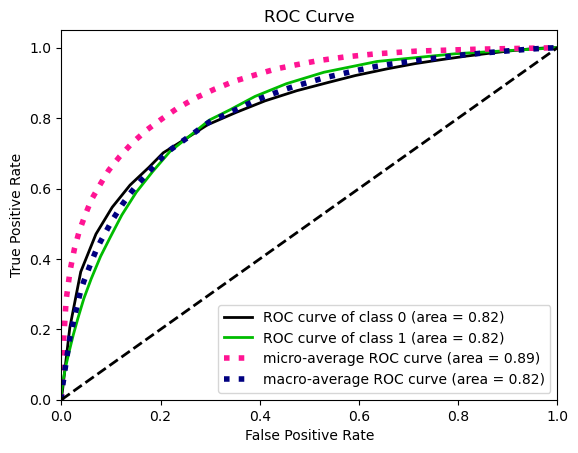

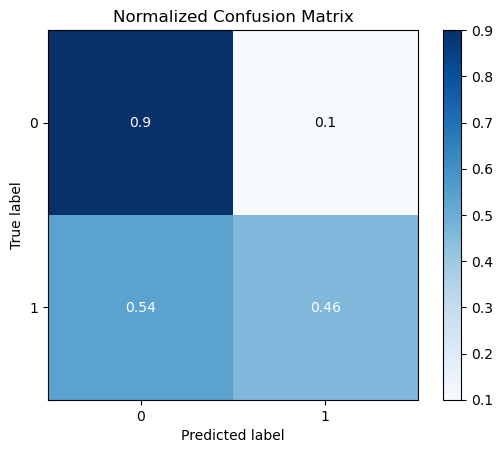

In [24]:
knn_pca = KNNWithPCA()

# Hyperparameter tuning with explained variance condition
param_grid = {
    'pca__n_components': [2,5,7,9,11,12,13,14],
    'knn__n_neighbors': [1,3, 5, 7, 10, 15,20,25,30],
}

best_params = knn_pca.tune_hyperparameters(tabular_data.X_train, tabular_data.y_train, param_grid)
print("Best hyperparameters:", best_params)
knn_pca.train(tabular_data.X_train, tabular_data.y_train)

# Plot Learning Curve
# knn_pca.plot_learning_curve(X_train, y_train, X_val, y_val, X_test, y_test)

# Evaluate the model on the test set
accuracy, report = knn_pca.evaluate(tabular_data.X_test, tabular_data.y_test)
print(f"Accuracy on test set: {accuracy}")
print("Classification Report on test set:\n", report)
knn_pca.plot_roc_curve(tabular_data.X_test, tabular_data.y_test)

# Plot Confusion Matrix
knn_pca.plot_confusion_matrix(tabular_data.X_test, tabular_data.y_test)


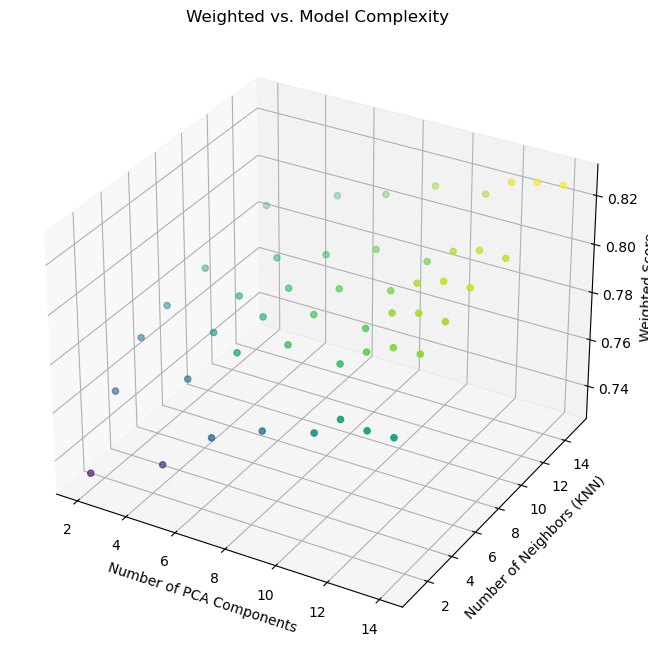

In [22]:
knn_pca.plot_metric_vs_complexity_3d(tabular_data.X_train, tabular_data.y_train, tabular_data.X_test, tabular_data.y_test,param_grid['pca__n_components'],param_grid['knn__n_neighbors'])


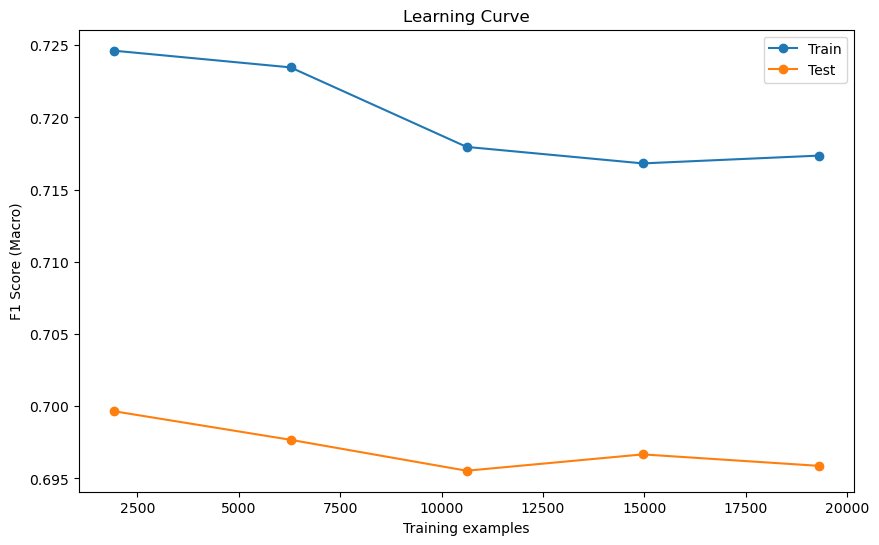

In [27]:
knn_pca.plot_learning_curve(tabular_data.X_train, tabular_data.y_train, tabular_data.X_val, tabular_data.y_val, tabular_data.X_test, tabular_data.y_test)
